# Example SFRmaker workflow
* requires packages listed at <https://github.com/aleaf/SFRmaker>  
(scroll down to **Dependencies**: preproc, postproc and diagnostics)

In [1]:
import sys
import os
import glob
sys.path += glob.glob('/Users/aleaf/Documents/GitHub/*')
# if preproc.py and postproc.py are in a different folder from this script,
# add that folder to the path so python can find it
sys.path.append('../')
import time

import numpy as np
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt
import flopy
from flopy.utils.reference import SpatialReference
from GISio import df2shp, shp2df
from rasterstats import zonal_stats
from preproc import NHDdata
from postproc import SFRdata
fm = flopy.modflow
%matplotlib inline

### SFRmaker input

In [2]:
# modflow files
mfdis ='example.dis'
mfnam ='example.nam'
model_ws = 'data'

outdir = 'temp' # folder for writing output
basename = 'example' # base filename for output
if not os.path.isdir(outdir):
    os.mkdir(outdir)

# output options
write_new_layer_bottoms = True # write new layer bottoms that are compatible with streambed bottoms
new_layer_bottoms_path = outdir
one_reach_per_cell = True # whether or not to allow multiple reaches in cells with meandering, confluences, etc.
# whether or not to consolidate conductances of SFR reaches
# (by adjusting hydraulic conductivity)
# so that only one reach in a cell has a non-zero conductance
# (True by defaul if one_reach_per_cell=True)
consolidate_conductance = False

# unit numbers
sfr_unit_number = 29,
sfr_leakage_unit_number = 53
sfr_output_unit_number = 66

# shapefiles defining the model grid, and the area that will include SFR
mf_grid = 'data/grid.shp'
mf_domain = 'data/domain.shp'

# NHDPlus input files (see the input requirements in the SFRmaker readme file
# (Note that multiple datasets can be supplied as lists;
# when the SFR area covers multiple drainage basins)
pfvaa_files = ['data/PlusFlowlineVAA.dbf']
plusflow_files = ['data/PlusFlow.dbf']
elevslope_files = ['data/elevslope.dbf']
flowlines = ['data/NHDFlowlines.shp']

# dem used for streambed elevations
dem = 'data/dem.tif'
dem_units_mult = 1. # convert dem elevation units to modflow units

## Set up the modflow model first

### grid location and discretization

In [3]:
xul, yul = 682668.5, 5147586.7 # UTM zone 15 N, nad27 meters (epsg code 26715)
nrow, ncol = 100, 160
dxdy = 250 # ft
delr = np.ones(nrow) * dxdy
delc = np.ones(ncol) * dxdy

### set up in flopy and export the grid to a shapefile

In [4]:
m = flopy.modflow.Modflow('example', model_ws='data')
dis = flopy.modflow.ModflowDis(m, nlay=1, nrow=nrow, ncol=ncol, delr=delc, delc=delr,
                               lenuni=1 # feet
                              )
m.sr = SpatialReference(delr=m.dis.delr, 
                        delc=m.dis.delc, 
                        xul=682668.5, yul=5147586.7, 
                        lenuni=1, # feet
                        proj4_str='EPSG:26715', rotation=0)
m.dis.export('data/grid.shp')

wrote data/grid.shp


### Sample elevations from the DEM using ```zonal_stats``` (```rasterstats``` package)

In [5]:
elevations = zonal_stats('data/grid.shp', 'data/dem.tif')

/Users/aleaf/anaconda3/envs/gis2/lib/python3.6/site-packages/rasterstats/main.py:161: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(fsrc.array.dtype, float) and \


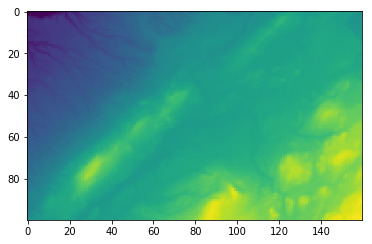

In [6]:
dem_mean = np.reshape([z['mean'] for z in elevations], (nrow, ncol))
plt.imshow(dem_mean)

### Set the model top elevations to the mean DEM value in each cell

In [7]:
dis.top = dem_mean
dis.botm = dem_mean - 100

In [8]:
m.write_input()

### make a shapefile of the active model domain  
(can be any area inside the grid; for this example set to extent of grid)

In [9]:
yll = yul - nrow * dxdy * .3048
xlr = xul + ncol * dxdy * .3048
domain = box(xul, yll, xlr, yul)
domain
df2shp(pd.DataFrame({'geometry':[domain]}), 'data/domain.shp', epsg=26715)

writing data/domain.shp...


## Running SFRmaker

### Initialize an NHDdata object  
* ```to_sfr`` performs the basic transfer of information to the grid, setting up the tables **Mat1** (reach data) and **Mat2** (segment data)

In [10]:
# Read in the NHD datasets
nhd = NHDdata(NHDFlowline=flowlines, PlusFlowlineVAA=pfvaa_files, PlusFlow=plusflow_files,
              elevslope=elevslope_files,
              mf_grid=mf_grid, mf_units='feet',
              nrows=100, ncols=160,
              model_domain=mf_domain)

# Setup the segments, reaches, and other basic SFR parameters
nhd.to_sfr(minimum_length=10., one_reach_per_cell=one_reach_per_cell,
           consolidate_conductance=consolidate_conductance)

Reading input...
+proj=utm +zone=15 +datum=NAD27 +units=m +no_defs 
+proj=longlat +datum=NAD83 +no_defs 
(-90.62437904647767, 46.38709783343725, -90.46278092845638, 46.45901882393651)

reading data/NHDFlowlines.shp...
--> building dataframe... (may take a while for large shapefiles)

reading data/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading data/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading data/elevslope.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading data/grid.shp...
--> building dataframe... (may take a while for large shapefiles)


/Users/aleaf/Documents/GitHub/SFRmaker/preproc.py:417: NodeIndexWarning: 
  warnings.warn(NodeIndexWarning(mf_grid))


reprojecting NHDFlowlines from
+proj=longlat +datum=NAD83 +no_defs 
to
+proj=utm +zone=15 +datum=NAD27 +units=m +no_defs ...

clipping flowlines to active area... (may take awhile for active area polygons with many vertices)
finished in 0.01s

setting up segments... (may take a few minutes for large networks)
getting routing information from NHDPlus Plusflow table...
assigning segment numbers...
finished in 0.03s

intersecting flowlines with grid cells...

Building spatial index...
finished in 1.83s

Intersecting 17 features...
17
finished in 0.24s

setting up reaches and Mat1... (may take a few minutes for large grids)
finished in 1.05s

computing widths...
multiplying length units by 3.280839895013123 to convert from GIS to MODFLOW...

setting up Mat2...
finished in 0.00s

Dropping 24 reaches with length < 10.00 ...

Assigning total SFR conductance to dominant reach in cells with multiple reaches...
Dropping 22 non-dominant reaches...

Repairing routing connections...

Done creating 

### Mat1

In [11]:
nhd.m1.head()

,comid,geometry,node,reach,segment,reachID,length,asum,width,roughch,...,i,j,k,strtop,ReachID,outreach,outseg,cond,Dominant,Cond_sum
861,1815711,LINESTRING Z (694812.4654326627 5141215.339349...,13439,1,1,1,95.230102,0.018594,0.519268,0.037,...,83,159,0,1380.555702,1,2,4,49.449939,True,49.449939
862,1815711,LINESTRING Z (694784.3 5141208.323302554 -5.48...,13438,2,1,2,259.725426,0.072689,1.031176,0.037,...,83,158,0,1378.884812,2,3,4,267.822654,True,267.822654
863,1815711,LINESTRING Z (694708.1 5141215.224587571 -5.48...,13437,3,1,3,140.559713,0.133693,1.401194,0.037,...,83,157,0,1377.000541,3,4,4,196.951381,True,196.951381
864,1815711,LINESTRING Z (694678.5982820526 5141185.9 -5.4...,13597,4,1,4,296.884556,0.200359,1.717557,0.037,...,84,157,0,1374.941350,4,5,4,509.916088,True,509.916088
865,1815711,LINESTRING Z (694631.9 5141111.867724131 -5.48...,13596,5,1,5,21.688605,0.248910,1.915706,0.037,...,84,156,0,1373.441724,5,6,4,41.548995,True,41.548995


### Mat2

In [12]:
nhd.m2.head()

,segment,outseg,elevup,elevdn,comid,icalc,width2,width1
segment,,,,,,,,
17,1,4,1381.003981,1278.149647,1815711,1,7.052280,0.519268
13,2,4,1297.867496,1278.149647,1814967,1,38.634924,38.443008
12,3,6,1400.853063,1211.286128,1814949,1,6.434265,2.610794
9,4,6,1278.149647,1211.286128,1814897,1,39.614897,39.298616
16,5,8,1300.885868,1162.926546,1815703,1,7.708425,0.755157


In [13]:
# Write out this information to Mat1 and Mat2 tables
nhd.write_tables(basename='{}/{}'.format(outdir, basename))

# Write out a shapefile that has the SFR linework
nhd.write_linework_shapefile(basename='{}/{}'.format(outdir, basename))

writing Mat1 to temp/exampleMat1.csv, Mat2 to temp/exampleMat2.csv
writing reach geometries to temp/example.shp
writing temp/example.shp...


### Initialize an SFRdata object to sample elevations

In [14]:
# Mat 1 and Mat2 files generated from preproc.py above
m1 = 'exampleMat1.csv'
m2 = 'exampleMat2.csv'

# Read in Mat1 and Mat2 into an SFRdata object (postproc module)
# also include MODFLOW DIS file, NAM file, and path to model datasets
sfr = SFRdata(Mat1=m1, Mat2=m2, mfgridshp=mf_grid,
              mfdis=mfdis, mfpath=model_ws,
              mfnam=mfnam)

# For interior stream reaches (not at the ends of segments),
# assign streambed tops from the minimum DEM elevations in the model cell
sfr.reset_m1_streambed_top_from_dem(dem, dem_units_mult=dem_units_mult)

# Often the NHDPlus elevations don't match DEM at scales below 100k.
# reset the segment end elevations to the minimum dem elevation
# encountered in the end reach and all reaches upstream
# (to use the NHDPlus elevations for the segment ends, comment this out)
sfr.reset_segment_ends_from_dem()

# Remove any bumps in the DEM elevations,
# so that interior elevations in the segments always decrease in the downstream direction
sfr.smooth_interior_elevations()

reading example.dis...

reading data/grid.shp...
--> building dataframe... (may take a while for large shapefiles)
computing zonal statistics...


/Users/aleaf/anaconda3/envs/gis2/lib/python3.6/site-packages/rasterstats/main.py:161: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(fsrc.array.dtype, float) and \


DEM min elevations assigned to sbtop column in m1

Smoothing segment interiors...

starting from elevations in m1.sbtop
calculating slopes...
Done, see smooth_segment_interiors.txt for report.


### Create Flopy SFR object  

In [15]:
# convert the m1 and m2 dataframes to input for Flopy
m1 = sfr.m1
m2 = sfr.m2
rd = fm.ModflowSfr2.get_empty_reach_data(len(m1))
sd = fm.ModflowSfr2.get_empty_segment_data(len(m2))

# dictionary to translate column names
sfrname = {
    'reach': 'ireach',
    'SFRlength': 'rchlen',
    'length': 'rchlen',
    'sbtop': 'strtop',
    'sbthick': 'strthick',
    'sbK': 'strhc1',
    'reachID': 'reachID',
    'outseg': 'outseg',
    'elevup': 'elevup',
    'elevdn': 'elevdn',
    'width1': 'width1',
    'width2': 'width2'
}

# populate the reach_data rec array
rd['i'] = m1.i.values
rd['j'] = m1.j.values
rd['k'] = 0
rd['iseg'] = m1.segment.values

for k, v in sfrname.items():
    if k in m1.columns and v in rd.dtype.names:
        rd[v] = m1[k].values

# populate the segment_data recarray
sd['nseg'] = m2.segment.values
sd['icalc'] = 1
sd['roughch'] = .037
for k, v in sfrname.items():
    if k in m2.columns:
        sd[v] = m2[k].values

# create the Flopy SFR object
sfr = fm.ModflowSfr2(m, nstrm=-len(m1), reach_data=rd, segment_data={0: sd},
                     isfropt=1, unit_number=sfr_unit_number,
                     ipakcb=sfr_leakage_unit_number,
                     istcb2=sfr_output_unit_number)
# assign K values from vertical
# compute the slopes
m.sfr.get_slopes()
# assign layers to the SFR
m.sfr.assign_layers(adjust_botms=True)

# write new external files for layer bottoms
if write_new_layer_bottoms:
    for i, l in enumerate(m.dis.botm.array):
        if not os.path.isdir(new_layer_bottoms_path):
            os.mkdir(new_layer_bottoms_path)
        ofn = os.path.join(new_layer_bottoms_path, 'botm{}.dat'.format(i + 1))
        np.savetxt(ofn, l, fmt='%.2f')
        print('wrote {}'.format(ofn))

wrote temp/botm1.dat


### Plot streambed elevations from segment 5 to the outlet

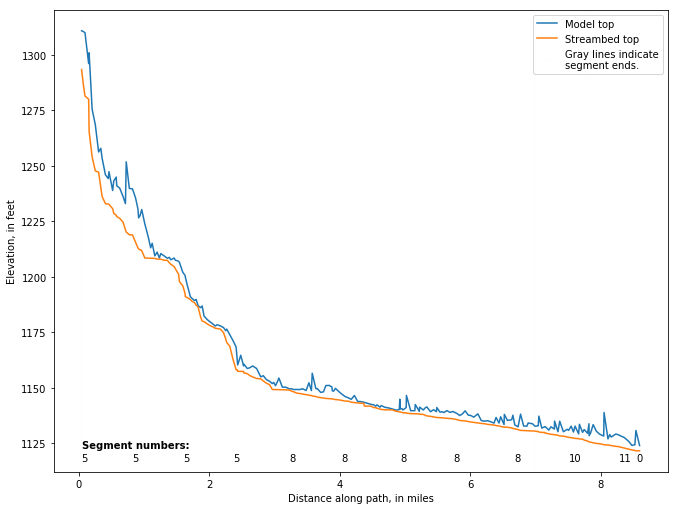

In [16]:
m.sfr.plot_path(5)

## Run Flopy checker on SFR package

In [17]:
# run diagnostics on the SFR and DIS packages
m.sfr.check('SFR.chk')
m.dis.check('DIS.chk')

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
1 segments with non-adjacent reaches found.
At segments:
4

1 segments with non-adjacent reaches found.
At segments:
4


Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=-871 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
15 reaches encountered with streambed above model top.
Model top violations:
i j iseg ireach strtop modeltop strhc1 reachID diff
87

### write SFR package and visualization shapefiles

In [18]:
# export shapefiles of SFR cells, routing connections and outlets
m.sfr.export('{}/{}_SFRcells.shp'.format(outdir, basename))
m.sfr.export_linkages('{}/{}_SFR_routing.shp'.format(outdir, basename))
m.sfr.export_outlets('{}/{}_SFR_outlets.shp'.format(outdir, basename))

# write the SFR package file
m.sfr.write_file('{}/{}.sfr'.format(outdir, basename))

No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.
wrote temp/example_SFRcells.shp
No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.
wrote temp/example_SFR_routing.shp
No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.
wrote temp/example_SFR_outlets.shp
